# 신경망 학습 (손실함수)

기계 학습 : 이미지 --> 사람이 생각한 알고리즘, 사람이 생각한 특징  --> 기계학습 --> 결과
    
딥러닝 : 이미지 --> 신경망(딥러닝) --> 결과
    
기계학습에서는 알고리즘을 짜거나 피쳐(특징)을 뽑을 때 사람이 개입해야하지만 딥러닝에서는 그런 과정조차 기계가 한다

딥러닝에서는 가지고 있는 데이터를 training_set 과 test_set으로 나눈다 : 범용성을 갖추기 위해서

--> 만약 training_set으로만 데이터를 모두 사용하여 학습 할 경우 overfitting이 일어날 가능성이 매우 높다

### 손실함수

최적의 매개변수 값을 탐색하는 지표(과정)

일반적으로 오차제곱합(SSE)과 교차 엔트로피 오차(Cross_Entropy_Error)를 사용

#### 오차제곱합(SSE)

In [4]:
def sum_squares_error(y,t):
    return 0.5 * np.sum((y-t)**2)

#### 교차 엔트로피 오차(CEE)

In [5]:
def cross_entropy_error(y,t):
    delta = 1e-7
    return -np.sum(t * np.log(y+delta))  #매우 작은 값 delta를 추가한 이유 : t가 0이된다면 np.log(t)는 정의되지 않으므로 계산이 중단된다. 그런 상황을 방지하기 위함이다.

#### 미니배치 학습 : 전체 데이터의 일부만 무작위로 뽑아서 학습. 데이터의 크기가 너무 클 때 사용 

In [8]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)


#이 train_data에서 무작위로 10장 추출하기
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) #train_size인 60000에서 batch_size인 10개의 수를 무작위로 뽑아내는 것
x_batch = x_train[batch_mask]  #뽑은 10개의 수를 인덱스로 사용하여 x_batch 추출
t_batch = t_train[batch_mask]

#### 교차 엔트로피 오차 구현 (batch_size 이용가능 ver.)

In [27]:
def cross_entropy_error(y,t):
    if y.ndim == 1:  #y가 1차원이라면, 즉 데이터 하나당 교차 엔트로피를 구하는 것이라면
        t = t.reshape(1,t.size)  #그에 따라 t,y데이터 reshape
        y = y.reshape(1,y.size)
    
    batch_size = y.shape[0]
    
    return -np.sum(t*np.log(y+1e-7)) / batch_size

#### y_label이 one_hot이 아닌 경우 (숫자로 주어질 경우)

In [17]:
def cross_entropy_error(y,t):
    if y.ndim == 1:  #y가 1차원이라면, 즉 데이터 하나당 교차 엔트로피를 구하는 것이라면
        t = t.reshape(1,t.size)  #그에 따라 t,y데이터 reshape
        y = y.reshape(1,y.size)
    batch_size = y.shape[0]
    
    return -np.sum(np.log(y[np.arange(batch_size),t] + 1e-7)) / batch_size  #np.arnage(batch_size)는 0~ batch_size -1의 배열을 생성한다. 각 데이터의 정답 레이블에 해당하는 신경망의 출력 추출

정확도가 아닌 손실함수를 매개변수의 초기화 지표로 사용하는 이유 : 정확도를 지표로 한다면 매개변수의 미분이 대부분의 장소에서 0이 된다.

--> 정확도 지표 사용시에는 변화가 불연속적이며, 미소한 변화에는 반응을 하지않는다. 미분을 이용한 초기화이기 때문에 잘 맞지 않음.

--> 손실함수는 연속적이고 기울기가 0이 되지 않기에 사용이 용이하다.

#### 미분 구현

In [10]:
#순수 미분
def numerical_diff(f,x):
    h = 10e-50  #반올림 오차 -> h = 10e-5정도가 적당
    return (f(x+h) - f(x)) / h  

# 문제점 : x라는 점에서의 기울기가 아니라, x+h와 x사이의 기울기를 구하는 것이다. h가 무한이 작아질수 없기 때문에(반올림오차) 오류
# --> 중앙 차분 사용

In [16]:
#중앙 차분
def numerical_diff(f,x):
    h = 1e-4
    return (f(x+h)-f(x-h)) / (2*h)  #중앙 차분을 이용하면 미분값이 어느정도 잘 구해짐

#### 수치 미분의 예시

In [12]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

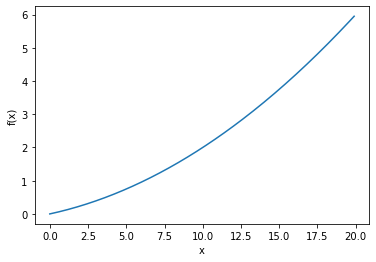

In [13]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0,20.0,0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x,y)
plt.show()

In [14]:
numerical_diff(function_1,5)

0.1999999999990898

In [15]:
numerical_diff(function_1,10)

0.2999999999986347

#### 기울기

In [20]:
def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x)  #x와 크기는 같으면서 모두 0으로 채워진 행렬을 만든다
    
    for idx in range(x.size):
        tmp_val = x[idx]
        #f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        #f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad

In [21]:
numerical_gradient(function_2, np.array([3.0,4.0]))
numerical_gradient(function_2, np.array([0.0,2.0]))

array([0., 4.])

-->기울기가 가리키는 쪽 : 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향

#### 경사 하강법

경사 하강법 : 기울기를 활용해 함수의 최솟값을 찾으려는 방법

In [24]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x
    
    for i in range(step_num):  #step_num : 경사법에 의한 반복 횟수
        grad = numerical_gradient(f,x)
        x -= lr*grad  #lr : 학습률, grad : 각 방향으로의 편미분
        
    return x

In [25]:
#학습률이 너무 크거나 작으면 안된다.
#학습률이 너무 큰 예
init_x = np.array([-3.0,4.0])
gradient_descent(function_2, init_x = init_x, lr = 10.0, step_num = 100)

array([-2.58983747e+13, -1.29524862e+12])

--> 너무 큰 값으로 발산해버린다

In [26]:
#학습률이 너무 작은 예
init_x = np.array([-3.0,4.0])
gradient_descent(function_2, init_x = init_x, lr = 1e-10, step_num = 100)

array([-2.99999994,  3.99999992])

--> 거의 갱신되지 않고 학습을 종료한다

하이퍼 파라미터 : 가중치, 편향 같이 기계가 자동으로 설정해주는 매개변수와는 다르게 사람이 직접 설정 해줘야 하는 매개변수 ex)학습률 lr

#### 신경망에서의 기울기 

--> 가중치 매개변수에 대한 손실 함수의 기울기 (dL/dW)

In [54]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

def softmax(a):
    c = np.max(a)  #a배열의 최대값. 오버플로우를 방지하기 위해서 사용한다.
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

def cross_entropy_error(y,t):
    if y.ndim == 1:  #y가 1차원이라면, 즉 데이터 하나당 교차 엔트로피를 구하는 것이라면
        t = t.reshape(1,t.size)  #그에 따라 t,y데이터 reshape
        y = y.reshape(1,y.size)
    
    batch_size = y.shape[0]
    
    return -np.sum(t*np.log(y+1e-7)) / batch_size

def cross_entropy_error(y,t):
    if y.ndim == 1:  #y가 1차원이라면, 즉 데이터 하나당 교차 엔트로피를 구하는 것이라면
        t = t.reshape(1,t.size)  #그에 따라 t,y데이터 reshape
        y = y.reshape(1,y.size)
    batch_size = y.shape[0]
    
    return -np.sum(np.log(y[np.arange(batch_size),t] + 1e-7)) / batch_size  #np.arnage(batch_size)는 0~ batch_size -1의 배열을 생성한다. 각 데이터의 정답 레이블에 해당하는 신경망의 출력 추출

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)  #2x3크기의 정규분포로 초기화
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
        
        return loss

In [55]:
net = simpleNet()
print(net.W)

x = np.array([0.6,0.9])
p = net.predict(x)
print(p)

np.argmax(p)

t= np.array([0,0,1])
net.loss(x,t)

[[-0.08762148 -0.52316084 -1.2444206 ]
 [-0.7319782   0.55704416 -0.00357649]]
[-0.71135327  0.18744324 -0.7498712 ]


3.558847131322864

In [56]:
def f(W):  #f(W)는 별 의미 없음. dummy 함수임, lambda를 쓰면 더 쉽게 표현 가능 --> f = lambda W : net.loss(x,t)
    return net.loss(x,t)

dW = numerical_gradient(f, net.W)
print(dW)

[[-0.79265466  0.4007016   0.39195306]
 [-1.18898199  0.6010524   0.58792959]]


lambda : 함수를 간단하게 표현하는 식.' lambda 인수 : 표현식 '으로 사용

미니 배치를 이용한 경사하강법 : 확률적 경사하강법 (SGD)

#### 2층 신경망 클래스 구현하기

In [57]:
import sys, os
sys.path.append(os.pardir)


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}  #순방향 처리에 사용되는 매개변수 저장
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self,x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x,W1) +b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self,x,t):
        y = self.predict(x)
        
        return cross_entropy_error(y,t)
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    def numerical_gradient(self,x,t):
        loss_W = lambda W : self.loss(x,t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

원래 신경망 생성시에 초기값이 매우 중요 but, 지금은 가중치는 난수로, 편향은 0으로 두자

#### 미니배치 학습 구현

In [60]:
import numpy as np 
from dataset.mnist import load_mnist

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)

train_loss_list = []
train_acc_list = []
test_acc_list = []
#1에폭 당 반복 수
iter_per_epoch = max(train_size/batch_size, 1)

#하이퍼 파라미터
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iters_num):
    #미니배치 획득
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #기울기 계산
    grad = network.numerical_gradient(x_batch,t_batch)  #나중에는 network.gradient로 사용할 것!(성능 개선)
    
    #매개변수 갱신 (gradient descent)
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    #학습 결과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc \ " + str(train_acc)+", " + str(test_acc))

IndexError: arrays used as indices must be of integer (or boolean) type